# 1.0 Processing and Model Training

### 1.1 Introduction

Image super-resolution (SR) is the process of recovering high-resolution (HR) images from low-resolution (LR) images. It is an important class of image processing techniques in computer vision and image processing and enjoys a wide range of real-world applications, such as medical imaging, satellite imaging, surveillance and security, astronomical imaging, amongst others.

Image super-resolution (SR) problem, particularly single image super-resolution (SISR), has gained a lot of attention in the research community. SISR aims to reconstruct a high-resolution image ISR from a single low-resolution image ILR. Generally, the relationship between ILR and the original high-resolution image IHR can vary depending on the situation. Many studies assume that ILR is a bicubic downsampled version of IHR, but other degrading factors such as blur, decimation, or noise can also be considered for practical applications. Interpolation-based methods such as nearest-neighbor, bilinear, splines, etc., often introduce some side effects such as computational complexity, noise amplification, blurring results, etc., that are no longer the factors in deep-learning based non-linear methods to achieve super resolution.

### 1.2 Problem

Electron microscopy images are very noisy. As the resolution increases, signal to noise ratio (SNR) becomes poorer. In addition, loger exposure to reduce the noise is not feasible due to stage movement that introduces motion blur in the image. To avoid the motion blur, conventional approach is to collect many images with a shortest pssible exposure time where the stage motion effect can be ignored and register those images with some correlation method and average the pixels that are common to all the images. This averaged image constitue to one single image with high SNR. Unfortuntely, multiple exposure of the specimens to electron beam damages the specimen. Each short exposure image frames may differ in statistical features although they are imaging the same specimen. This degrades the image quality.
Is there a way to reduce the noise level in short exposure image frames and use only a few imge frames to average that can significantly increase the SNR of the image.

There is (in general) no relationship between the noise in neighboring pixels. Technical junkies call this “no correlation”. Correlation is the long-term average of the product of two signals N1 x N2. If two signals have no correlation, then the mean of their product is zero. The signal in neighboring pixels has a high degree of correlation. If you add uncorrelated signals, then their “power” is added, meaning the combined signal is the square root of the combined power.

N_comb = sqrt(N1^2+N2^2) and for N1 = N2 = N we get N_comb = sqrt(2)*N, where N1, N2 are root-mean-square (RMS) values of the noise.

However, if signals are highly correlated, then their sum is effectively the sum of their magnitudes:

S_comb = S1+S2 and for S1=S2=S we get S_comb = 2*S

So, if we add the content of two neighboring pixels, we get:

SNR_comb = S_comb/N_comb = sqrt(2)*(S/N)

So, the signal-to-noise increases by square root of two, which is about 40%.

We propose deep-learning encoder-decoder architecture to reduce the noise in individual short exposure time images (called image frames) while increasing the resolution by 4X upsampling. This significantlt reduces the noise and increases the SNR but is hard to mathematically quantify. The final image is down-sampled with conventional methods where every 2X down sampling increases the SNR by 40% as per above known theory.

## 1.3 Datasets

Super-resolution by machine learning process require image pairs consisting of one low-resolution image and the corresponding high resolution image (of the same specimen). High resolution image can be 2X or 4X, etc. larger than the low-resolution image in number of pixels but the field of view should remain exactly same to avoid any unwanted artifact generation.

In electron microscopy, data is generated as a number of image frames of low exposure time which then appropriately registered and integrated to create a final image where noise is reduced and blur due to stage drift is removed.

We have about 10 images. Each image is produced by registering 16 low exposure image frames. So, each image provides us 16 pairs of datasets.

In [4]:
import numpy as np
import glob
import skimage.io
import cv2
import matplotlib.pyplot as plt

15


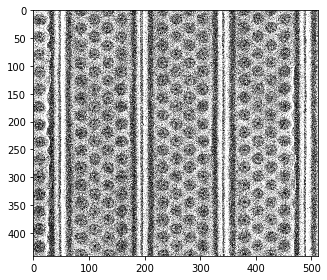

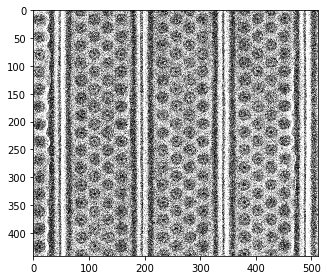

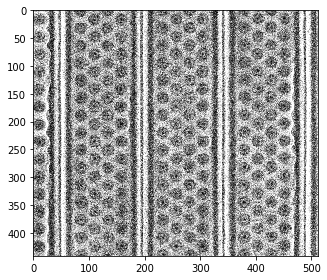

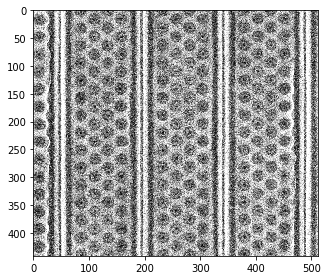

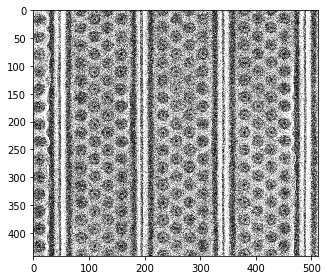

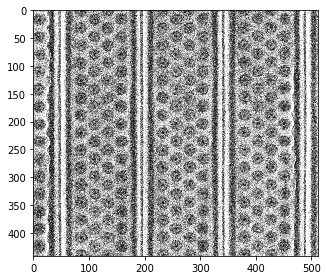

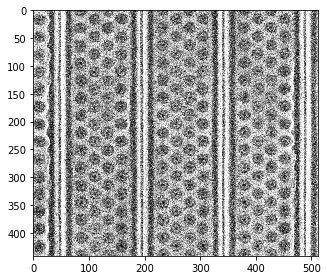

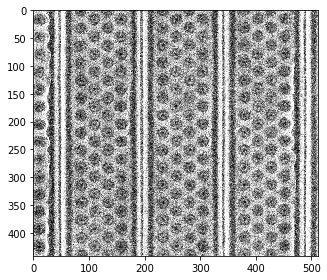

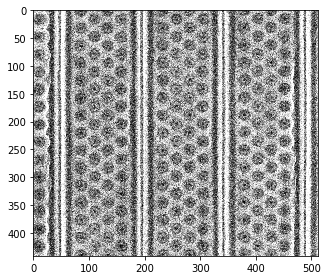

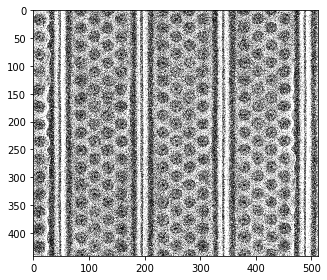

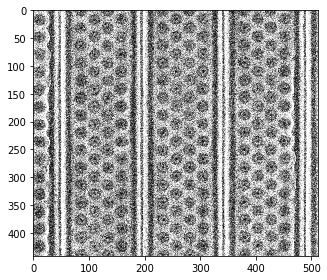

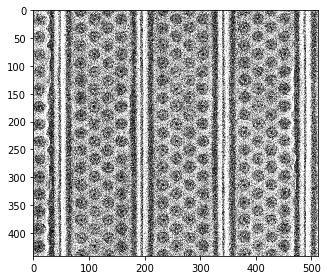

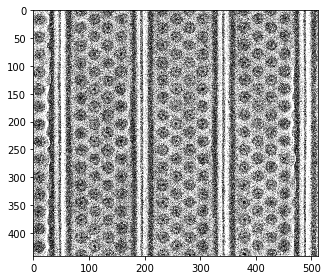

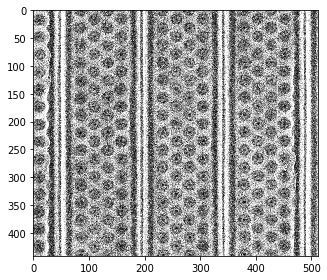

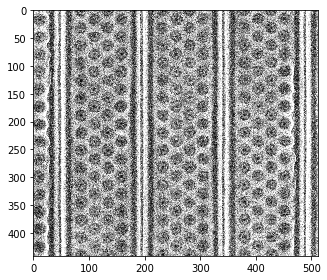

In [9]:
# Read low res training images
files = glob.glob(r'D:\myData\DCFI\sangSet4\*.tif', recursive=True)
print(len(files))
for file in files: 
    lr_img = skimage.io.imread(file)
    lr_img = np.array(lr_img)
    lr_img = cv2.resize(lr_img, (int(lr_img.shape[1]/4), int(lr_img.shape[0]/4)))
    skimage.io.imshow(lr_img)
    plt.show()

The corresponding high resolution image is 

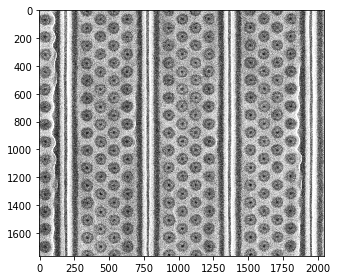

In [10]:
hr_img = skimage.io.imread(r'D:\myData\DCFI\sangSet4\results\DcfiImage_Frame_0_2019-07-10_15-01-44-241_traditional.png')
hr_img = np.array(hr_img)
skimage.io.imshow(hr_img)
plt.show()

### 2.0 Data Wrangling

Here data wrangling is simply to read all the low resolution and high resolution data sets, make corresponding pairs and save it in an appropriately named folder

All the low resolution images are sub-sampled by 4X (reduced in size by 4X) so that we carete approprate image pars (lr, hr) that are (1X, 4X) in number of pixels/uitarea. For now we have collected 10 dataset folders. each dataset folder has 16 low resolution (or say noisy, low exposure images) and one noise reduced, drift corrected image. So we take following processing steps called "data augmentation" to create large number of datasets (approximately 25000 image pairs) for training and validation of the machine learning process.

### 2.1 Data Augmentation

In [ ]:
lr_path = r"D:\myData\IntegratedMetrology\data\train\lr"
if not os.path.exists(lr_path):
    os.makedirs(lr_path)
hr_path = r"D:\myData\IntegratedMetrology\data\train\hr"
if not os.path.exists(hr_apth):
    os.makedirs(hr_path)
    
path0 = r"D:\myData\IntegratedMetrology\data\frames"

xfiles=[]
yfiles=[]
directory_contents = os.listdir(path0)
for item in directory_contents:
    x_dataPath = os.path.join(path, item)
    xfiles = glob.glob(x_dataPath)
    y_dataPath =x_dataPath + "\\dcfi"
    yfiles = glob.glob(y_dataPath)

count = 0;
maxCount = 25000;
siz = 128;
xst = 0;
yst = 0;
xflag = True;
yflag = True;
while (count <= maxCount):
    for i in range(0, len(xfiles)):
        if (count > maxCount): 
            break; 

        imgx = skimage.io.imread(xfiles[i])
        imgy = skimage.io.imread(yfiles[0]) # there is only one high res DCFI image and it corresponds all low-exposure image frames to make pairs
        imgy = cv2.resize(imgy, imgx.shape()) # just making sure that LR and HR are of same size to begin with

        if (count > maxCount): 
            break
        for y in range(yst, imgx.shape[1], int(siz/2)):
            if (count > maxCount):
                break
            for x in range(xst, imgx.shape[0], int(siz/2)):
                if (count > maxCount):
                    break
                if (((imgx.shape[0] - x) < siz) || ((imgx.shape[1] - y) < siz)):
                    continue
                picx = np.array(imgx[x:(x+siz), y:(y+siz)], dtype=np.float)
                picx = 255 * (np.min(pix))/(np.max(picx) - np.min(picx))
                picx = np.array(picx, dtype=np.uint8)
                picy = np.array(imgy[x:(x+siz), y:(y+siz)], dtype=np.float)
                picy = 255 * (np.min(piy))/(np.max(picx) - np.min(picx))
                picy = np.array(picy, dtype=np.uint8)

                outName = " "
                outNamey = " "
                if (count < 10):
                    outName = outPath0 + "0000" + str(count) + ".png"
                    outNamey = outPath1 + "0000" + str(count) + ".png"                           
                elif ((count < 100) && (count>=10))
                    outName = outPath0 + "000" + str(count) + ".png"
                    outNamey = outPath1 + "000" + str(count) + ".png" 
                elif ((count < 1000) && (count>=100))
                    outName = outPath0 + "00" + str(count) + ".png"
                    outNamey = outPath1 + "00" + str(count) + ".png" 
                elif ((count < 10000) && (count>=1000))
                    outName = outPath0 + "0" + str(count) + ".png"
                    outNamey = outPath1 + "0" + str(count) + ".png"
                elif ((count < 100000) && (count>=10000))
                    outName = outPath0 + str(count) + ".png"
                    outNamey = outPath1  + str(count) + ".png" 

                cv2.imwrite(outName, picx)
                cv2.imwrite(outNamey, picy)

                count=count+1

            if (xflag):
                yst += siz / 2
                xflag = !xflag
            else
                xst += siz / 2
                xflag = !xflag              

##### Above augmentation process was actually written in C# and executed (due to some system requirements to access companay image database.

This has resulted in 25000 image pairs of low-resolution image of size 128X128 pixels and high resolution images of size 512X512 pixels. An additional dataset of noiseless DCFI images of 128X128 is also created for training noise reduction models.

In [11]:
#Load general libaries to be used
import numpy as np
import glob
import skimage.io
import skimage.exposure
import cv2

In [12]:
#Load deep-learning libraries such as tensorflow and the easy to use wrappers for tensorflow methods using keras
import tensorflow as tf
from tensorflow.keras import Model, Input, regularizers
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, UpSampling2D, Add, Dropout, Lambda
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [13]:
path = "D:\\myData\\ML_Quality\\4X"
x_train_dataPath = path+"\\x_train_highres_4X\\*.png"
print(x_train_dataPath)
y_train_dataPath = path+"\\y_train_highres_4X\\*.png"
print(y_train_dataPath)

D:\myData\ML_Quality\4X\x_train_highres_4X\*.png
D:\myData\ML_Quality\4X\y_train_highres_4X\*.png


Here we read the data sets and split them into training and validation datasets

In [15]:
# Read training images and splitting them in training and validation sets (75% training and 25% validation)
files = glob.glob(x_train_dataPath, recursive=True)
print(len(files))

x_train=[]
x_valid=[]
ct=0;
for file in files: 
    img = skimage.io.imread(file)
    img = np.array(img)
    if ct%4 ==0:
        x_valid.append(img)
        ct=ct+1
    else:
        x_train.append(img)
        ct=ct+1
        

print("length of low res training data set: ", len(x_train))
print("length of low res validation datasets:", len(x_valid))

print("shape of low res training data: ", x_train[0].shape)
print("shape of low res validation data: ", x_valid[0].shape)

7002
length of low res training data set:  5251
length of low res validation datasets: 1751
shape of low res training data:  (128, 128)
shape of low res validation data:  (128, 128)


In [16]:
ct=0

files = glob.glob(y_train_dataPath)
print(len(files))

### for noise reducer
xy_train=[]
xy_valid=[]
### for super resolution
y_train=[]
y_valid=[]

for file in files: 
    img = skimage.io.imread(file)         
    img = np.array(img)
    if ct%4 ==0:
        ct=ct+1
        y_valid.append(img)
        imgx = cv2.resize(img, x_train[0].shape, interpolation=cv2.INTER_AREA)
        xy_valid.append(imgx)
    else:
        y_train.append(img)
        imgx = cv2.resize(img, x_train[0].shape, interpolation=cv2.INTER_AREA)
        xy_train.append(imgx)
        ct=ct+1
        
print("length of low high-res noise reduction training data sets: ", len(xy_train))
print("length of low high-res noise reduction validation data sets: ", len(xy_valid))
print("length of high-res super resolution training data sets: ", len(y_train))
print("length of high-res super resolution validation data sets: ",len(y_valid))
print("shape of low high-res noise reduction training data set: ",xy_train[0].shape)
print("shape of low high-res noise reduction validation data set: ",xy_valid[0].shape)
print("shape of high-res super resolution training data set: ",y_train[0].shape)
print("shape of high-res super resolution validation data set: ",y_valid[0].shape)

7002
length of low high-res noise reduction training data sets:  5251
length of low high-res noise reduction validation data sets:  1751
length of high-res super resolution training data sets:  5251
length of high-res super resolution validation data sets:  1751
shape of low high-res noise reduction training data set:  (128, 128)
shape of low high-res noise reduction validation data set:  (128, 128)
shape of high-res super resolution training data set:  (512, 512)
shape of high-res super resolution validation data set:  (512, 512)


#### Additional dimensionality changes as required by the tensorflow deep-learning library by google is executed here

In [18]:
#some rearranging of data dimensions, etc.. to suit tensorflow requirements
x_train = np.dstack(x_train)
x_train = np.rollaxis(x_train,-1)
x_valid = np.dstack(x_valid)
x_valid = np.rollaxis(x_valid,-1)
xy_train = np.dstack(xy_train)
xy_train = np.rollaxis(xy_train,-1)
xy_valid = np.dstack(xy_valid)
xy_valid = np.rollaxis(xy_valid,-1)
y_train = np.dstack(y_train)
y_train = np.rollaxis(y_train,-1)
y_valid = np.dstack(y_valid)
y_valid = np.rollaxis(y_valid,-1)

In [19]:
###We also have to reshape our NumPy array as the current shape of the datasets is (Ntrain, X, Y, 1) and (Nvalid, X, Y, 1). 
###We need to add a fourth dimension with a single value (e.g., from (Ntrain, X, Y,1) to (Ntrain, X, Y, 1, 1));
x_train = x_train[:,:,:, tf.newaxis]
x_valid = x_valid[:,:,:, tf.newaxis]
xy_train = xy_train[:,:,:, tf.newaxis]
xy_valid = xy_valid[:,:,:, tf.newaxis]
y_train = y_train[:,:,:, tf.newaxis]
y_valid = y_valid[:,:,:, tf.newaxis]

print("Final 1X low res shape: ", x_train.shape) ## 1X
print("Final 1X high res shape: ",xy_train.shape) ## 1X for noise reducer
print("Final 4X high res shape: ",y_train.shape) ## 4X for super resolution

Final 1X low res shape:  (5251, 128, 128, 1)
Final 1X high res shape:  (5251, 128, 128, 1)
Final 4X high res shape:  (5251, 512, 512, 1)


##### These datasets are then used for training and validation deep-learning models as described in next submissions of capstone3 project.